# **Cassava Leaf Disease Classification: CNN Keras Baseline**
![Cassava](https://scx2.b-cdn.net/gfx/news/2019/3-geneeditingt.jpg)

As the second-largest provider of carbohydrates in Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an added challenge, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

### Table of contents:
1. [**First look at the data**](#section-one)
2. [**The baseline level of accuracy**](#section-two)
3. [**Modeling**](#section-three)
4. [**Prediction**](#section-four)


### History of changes:

**Ver.4:** Changed strategy for train/valid splitting; EfficientNetB0 was chosen as a baseline network for future work.

**Ver.5:** Changed some parameters of ImageDataGenerator.

**Ver.6:** Changed some parameters of ImageDataGenerator.

**Ver.7-8:** Changed batch size.

**Ver.9:** Changed batch size and 'factor' parameter (ReduceLROnPlateau callback).


## Notebook with prediction: [Cassava Leaf Disease: Keras CNN prediction](https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-keras-cnn-prediction)

## See also the last part of this work with my best CNN: [Cassava Leaf Disease: Best Keras CNN](https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-best-keras-cnn)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image

## Work directory

In [2]:
WORK_DIR = '../input/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

<a id="section-one"></a>
# First look at the data

In [3]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [4]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [5]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


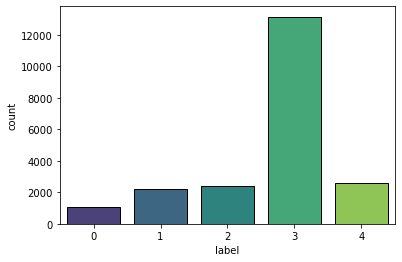

In [6]:
sns.countplot(train_labels.label, edgecolor = 'black',
              palette = sns.color_palette("viridis", 5))
plt.show()

We have imbalanced data with domination of third class: "Cassava Mosaic Disease (CMD)"

## Some photos of dominant class (with CMD)

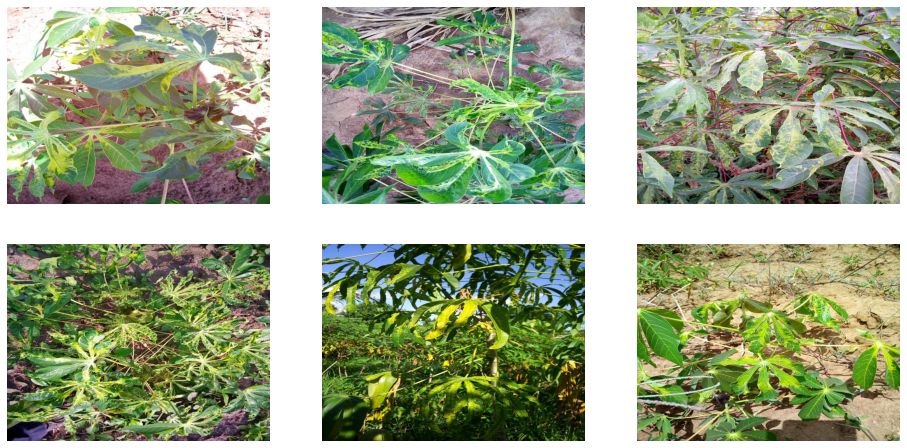

In [7]:
sample = train_labels[train_labels.label == 3].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

## Some photos of healthy plants

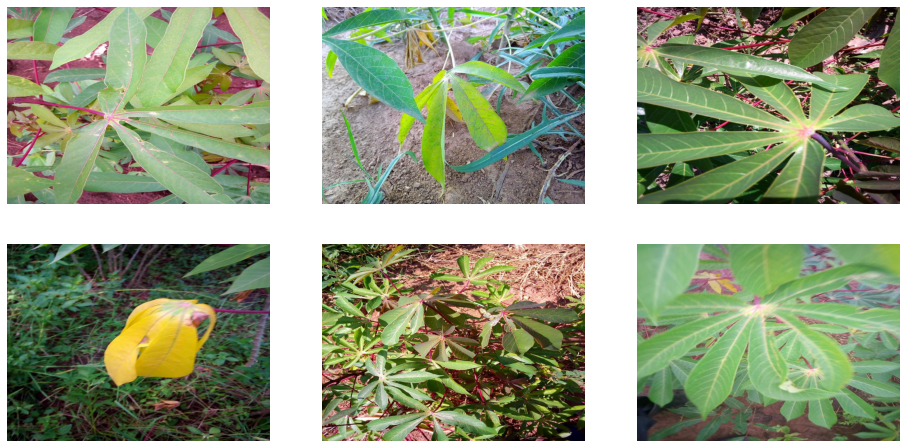

In [8]:
sample = train_labels[train_labels.label == 4].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

<a id="section-two"></a>
# The baseline level of accuracy

In [9]:
y_pred = [3] * len(train_labels.label)
print('The baseline accuracy: %.3f' 
      %accuracy_score(y_pred, train_labels.label))

The baseline accuracy: 0.615


Our future model must have accuracy better than 0.615.

<a id="section-three"></a>
# Modeling

In [10]:
# The TRAIN/VALID split is performing in the generator directly.

#train, valid = train_test_split(train_labels, train_size = 0.8, shuffle = True,
#                                random_state = 0)

In [11]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
#sns.set_style("white")
#plt.suptitle('Train vs Valid labels', size = 15)
#
#sns.countplot(train.label, edgecolor = 'black', ax = ax1,
#              palette = sns.color_palette("viridis", 5))
#sns.countplot(valid.label, edgecolor = 'black', ax = ax2,
#              palette = sns.color_palette("viridis", 5))
#plt.show()

In [12]:
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 20
TARGET_SIZE = 224

In [13]:
train_labels.label = train_labels.label.astype('str')

train_generator = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     zoom_range = 0.2,
                                     cval = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.2,
                                     height_shift_range = 0.2,
                                     width_shift_range = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

validation_generator = ImageDataGenerator(validation_split = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


After some experiments with various pre-trained networks, I've stopped on [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0). It will be my baseline NN for future improvements.

In [14]:
def create_model():
    model = models.Sequential()

    model.add(EfficientNetB0(include_top = False, weights = 'imagenet',
                             input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation = "softmax"))

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [15]:
model = create_model()
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


In [16]:
model_save = ModelCheckpoint('./best_baseline_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit_generator(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/20
1070/1069 [==============================] - ETA: 0s - loss: 0.7252 - acc: 0.7398
Epoch 00001: val_loss improved from inf to 0.74652, saving model to ./best_baseline_model.h5
1070/1069 [==============================] - 487s 455ms/step - loss: 0.7252 - acc: 0.7398 - val_loss: 0.7465 - val_acc: 0.7284
Epoch 2/20
1070/1069 [==============================] - ETA: 0s - loss: 0.5867 - acc: 0.7898
Epoch 00002: val_loss improved from 0.74652 to 0.54949, saving model to ./best_baseline_model.h5
1070/1069 [==============================] - 408s 382ms/step - loss: 0.5867 - acc: 0.7898 - val_loss: 0.5495 - val_acc: 0.8088
Epoch 3/20
1070/1069 [==============================] - ETA: 0s - loss: 0.5531 - acc: 0.8058
Epoch 00003: val_loss improved from 0.54949 to 0.54799, saving model to ./best_baseline_model.h5
1070/1069 [==============================] - 406s 380ms/step - loss: 0.5531 - acc: 0.8058 - val_loss: 0.5480 - val_acc: 0.8051
Epoch 4/20
1070/1069 [==============================]

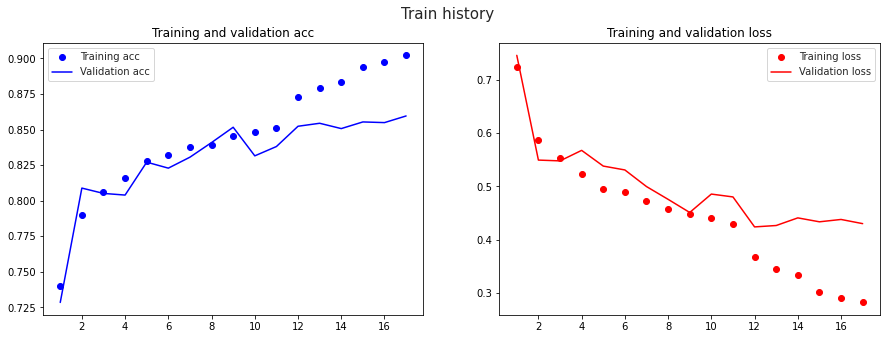

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [18]:
model.save('./baseline_model.h5')

<a id="section-four"></a>
# Prediction

In [19]:
ss = pd.read_csv(os.path.join(WORK_DIR, "sample_submission.csv"))
ss

,image_id,label
0,2216849948.jpg,4


In [20]:
preds = []

for image_id in ss.image_id:
    image = Image.open(os.path.join(WORK_DIR,  "test_images", image_id))
    image = image.resize((TARGET_SIZE, TARGET_SIZE))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(model.predict(image)))

ss['label'] = preds
ss

,image_id,label
0,2216849948.jpg,4


In [21]:
ss.to_csv('submission.csv', index = False)

## SEE [PREDICTION VERSION OF THIS NOTEBOOK](https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-keras-cnn-prediction)

## AND NOTEBOOK WITH MY BEST CNN: [Cassava Leaf Disease: Best Keras CNN](https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-best-keras-cnn)